In [ ]:
import os
import PIL.Image
import weave
import numpy as np
import PIL
import matplotlib.pyplot as plt

os.environ['WANDB_API_KEY'] = "bdc8857f9d6f7010cff35bcdc0ae9413e05c75e1"
weave.init('aghiles-kebaili/federated-pet') # 🐝

input_image = np.load('./data/13_16_33.npy')
input_image = input_image[input_image.shape[0] // 2]

input_image = input_image / input_image.max()
input_image = input_image + np.random.normal(0, 0.1, input_image.shape)

cmap = plt.get_cmap('hot')
input_image = cmap(input_image)
input_image = (input_image[:, :, :3] * 255).astype(np.uint8)
input_image = PIL.Image.fromarray(input_image)

@weave.op() # 🐝 Decorator to track requests
def testing_weave(input_image: PIL.Image) -> PIL.Image:
    # ... generating output image ...
    # outputing the generating image as PIL image
    output_image = input_image
    return output_image

testing_weave(input_image)


### Je check les valeurs SUV (max, min, moyenne)

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from tqdm import tqdm

ROOT = '../datasets/EARL/Ano_Nifti/'

subjects = os.listdir(ROOT)[:100]
placeholder = np.zeros(shape=(subjects.__len__(), 3), dtype=np.float32)

for s, subject in tqdm(enumerate(subjects), position=0, leave=True, total=subjects.__len__()):
    subject_path = os.path.join(ROOT, subject)
    simgs = os.listdir(subject_path)

    for img_name in simgs:
        # filtering only PT images
        if not img_name.startswith('PT') or 'EARL' in img_name:
            continue

        img_path = os.path.join(subject_path, img_name)
        img_nii = nib.load(img_path).get_fdata()
        
        placeholder[s, 0] = img_nii.min()
        placeholder[s, 1] = img_nii.max()
        placeholder[s, 2] = img_nii.mean()
    
        
    


100%|██████████| 100/100 [00:59<00:00,  1.68it/s]


In [47]:
rand_indices = np.random.choice(subjects.__len__(), size=10, replace=False)
for idx in rand_indices:
    print(f"Subject: {subjects[idx]}, Min: {placeholder[idx, 0]}, Max: {placeholder[idx, 1]}, Mean: {placeholder[idx, 2]}")

Subject: 9401190790m, Min: 0.0, Max: 12.866623878479004, Mean: 0.023959901183843613
Subject: 9401189726m, Min: 0.0, Max: 24.14497947692871, Mean: 0.026275796815752983
Subject: 9401186744m, Min: 0.0, Max: 19.535802841186523, Mean: 0.0661429688334465
Subject: 9401170220m, Min: 0.0, Max: 4.9171833992004395, Mean: 0.03137609735131264
Subject: 9401167786m, Min: 0.0, Max: 14.460616111755371, Mean: 0.021418126299977303
Subject: 9401168770m, Min: 0.0, Max: 13.302177429199219, Mean: 0.027970507740974426
Subject: 9401154302m, Min: 0.0, Max: 4.757358074188232, Mean: 0.024020418524742126
Subject: 9401171676m, Min: 0.0, Max: 18.70843505859375, Mean: 0.03658916801214218
Subject: 9401164896m, Min: 0.0, Max: 5.504562854766846, Mean: 0.0263146311044693
Subject: 9401164485m, Min: 0.0, Max: 4.946689605712891, Mean: 0.0276942141354084


### Testing the MIP Dataset class

In [6]:
import torch
import numpy as np
from modules.data import MIPDataset

dataset = MIPDataset(
    root='./data/federated-pet/Ano_Nifti/', 
    pattern='PT_TEPTAPAC_Ano_MIP',
    random_crop_size=(128, 128),
    horizontal_flip=0.5,
    vertical_flip=0.5,
    dtype='float32'
)
dataset

In [7]:
for idx in range(dataset.__len__()):
    sample = dataset[idx]
    print(f"Sample {idx}: Image shape: {sample['image'].shape}, Dtype: {sample['image'].dtype}")

Sample 0: Image shape: torch.Size([1, 128, 128]), Dtype: torch.float32
Sample 1: Image shape: torch.Size([1, 128, 128]), Dtype: torch.float32
Sample 2: Image shape: torch.Size([1, 128, 128]), Dtype: torch.float32
Sample 3: Image shape: torch.Size([1, 128, 128]), Dtype: torch.float32
Sample 4: Image shape: torch.Size([1, 128, 128]), Dtype: torch.float32
Sample 5: Image shape: torch.Size([1, 128, 128]), Dtype: torch.float32
Sample 6: Image shape: torch.Size([1, 128, 128]), Dtype: torch.float32
Sample 7: Image shape: torch.Size([1, 128, 128]), Dtype: torch.float32
Sample 8: Image shape: torch.Size([1, 128, 128]), Dtype: torch.float32
Sample 9: Image shape: torch.Size([1, 128, 128]), Dtype: torch.float32
Sample 10: Image shape: torch.Size([1, 128, 128]), Dtype: torch.float32
Sample 11: Image shape: torch.Size([1, 128, 128]), Dtype: torch.float32
Sample 12: Image shape: torch.Size([1, 128, 128]), Dtype: torch.float32
Sample 13: Image shape: torch.Size([1, 128, 128]), Dtype: torch.float32
Sa

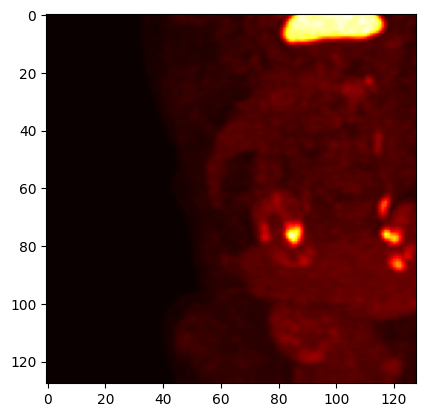

In [22]:
import matplotlib.pyplot as plt
plt.imshow(dataset[0]['image'].squeeze(), cmap='hot')

In [38]:
from modules.data import MIPDataModule
from modules.utils import set_seed

set_seed(43)

datamodule = MIPDataModule(
    root='./data/federated-pet/Ano_Nifti/', 
    pattern='PT_TEPTAPAC_Ano_MIP',
    train_ratio=0.9,
    batch_size=8,
    num_workers=4,
    random_crop_size=(128, 128)
)

datamodule.prepare_data()
datamodule.setup()

datamodule.train_dataset.paths

Seed set to 43


Seed set to 43 with deterministic=False
Discovered 19 MIP files under ./data/federated-pet/Ano_Nifti/ with pattern 'pt_teptapac_ano_mip'
  Training samples: 17
  Validation samples: 2


['./data/federated-pet/Ano_Nifti/9401154964m\\PT_TEPTAPAC_Ano_MIP.nii.gz',
 './data/federated-pet/Ano_Nifti/9401154754m\\PT_TEPTAPAC_Ano_MIP.nii.gz',
 './data/federated-pet/Ano_Nifti/9401154325m\\PT_TEPTAPAC_Ano_MIP.nii.gz',
 './data/federated-pet/Ano_Nifti/9401154744m\\PT_TEPTAPAC_Ano_MIP.nii.gz',
 './data/federated-pet/Ano_Nifti/9401154752m\\PT_TEPTAPAC_Ano_MIP.nii.gz',
 './data/federated-pet/Ano_Nifti/9401154749m\\PT_TEPTAPAC_Ano_MIP.nii.gz',
 './data/federated-pet/Ano_Nifti/9401154756m\\PT_TEPTAPAC_Ano_MIP.nii.gz',
 './data/federated-pet/Ano_Nifti/9401154763m\\PT_TEPTAPAC_Ano_MIP.nii.gz',
 './data/federated-pet/Ano_Nifti/9401154742m\\PT_TEPTAPAC_Ano_MIP.nii.gz',
 './data/federated-pet/Ano_Nifti/9401154314m\\PT_TEPTAPAC_Ano_MIP.nii.gz',
 './data/federated-pet/Ano_Nifti/9401154753m\\PT_TEPTAPAC_Ano_MIP.nii.gz',
 './data/federated-pet/Ano_Nifti/9401154750m\\PT_TEPTAPAC_Ano_MIP.nii.gz',
 './data/federated-pet/Ano_Nifti/9401154305m\\PT_TEPTAPAC_Ano_MIP.nii.gz',
 './data/federated-pet/An

### Deleting MIP files

In [162]:
import os
from tqdm import tqdm

ROOT = '../datasets/EARL/Rennes_Nifti/'
subjects = os.listdir(ROOT)
for s, subject in tqdm(enumerate(subjects), position=0, leave=True, total=subjects.__len__()):
    subject_path = os.path.join(ROOT, subject)
    simgs = os.listdir(subject_path)

    for img_name in simgs:
        # deleting MIP images, files containing 'MIP' in their names
        if 'MIP' in img_name:
            img_path = os.path.join(subject_path, img_name)
            os.remove(img_path)

100%|██████████| 77/77 [00:00<00:00, 13631.09it/s]


### Testing the VAE

In [4]:
from modules.models.autoencoders import VariationalAutoencoder
from omegaconf import OmegaConf
import torch

config = OmegaConf.load('configs/reconstruct_model.yaml')
config = OmegaConf.to_container(config, resolve=True)

model = VariationalAutoencoder.load_from_checkpoint('./runs/patch-reconstruction-model-64x64/2025_11_21_152448/last.ckpt')
model = model.eval()
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

Setting up [baseline] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/home/aghiles/anaconda3/envs/work_p11/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aghiles/anaconda3/envs/work_p11/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [1]:
from modules.data import MIPDataset, MIPDataModule
from omegaconf import OmegaConf

config = OmegaConf.load('configs/reconstruct_model.yaml')
config = OmegaConf.to_container(config, resolve=True)

config['datamodule']['root'] = '../datasets/EARL/Rennes_Nifti/'
config['datamodule']['pattern'] = '_AC_MIP'
config['datamodule']['train_ratio'] = 0.02  # Use all data for validation/testing

datamodule = MIPDataModule(**config['datamodule'])
datamodule.prepare_data()
datamodule.setup()

val_paths = datamodule.val_dataset.paths

validation_dataset = MIPDataset(
    paths=val_paths,
    cache_after_load=True,
    normalize=True,
    dtype='float32'
)

Discovered 77 MIP files under ../datasets/EARL/Rennes_Nifti/ with pattern '_ac_mip'
  Training samples: 1
  Validation samples: 76


MIP Image metadata: (torch.Size([1, 1, 447, 200]), 1.0241057872772217, 1.8432823419570923)


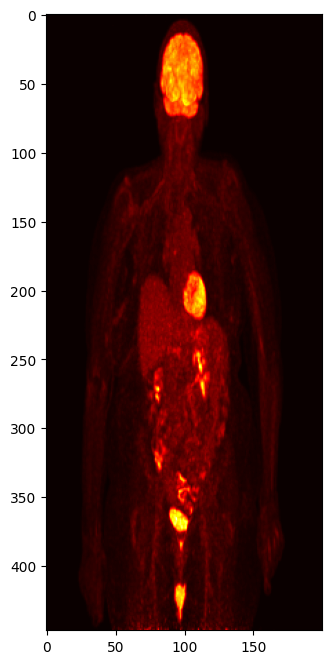

In [6]:
import numpy as np
import matplotlib.pyplot as plt

sample = validation_dataset[np.random.randint(validation_dataset.__len__())]
random_mip_image = sample['image'].unsqueeze(0).to(model.device)
mean, std = sample['mean'], sample['std']
print('MIP Image metadata: {}'.format((random_mip_image.shape, mean, std)))

plt.figure(figsize=(2 * int(random_mip_image.shape[-2] // 100), 4 * int(random_mip_image.shape[-1] // 100)))
plt.imshow(random_mip_image.squeeze().cpu(), cmap='hot')
plt.show()

In [38]:
import numpy as np
import torch
from tqdm import tqdm

@torch.no_grad()
def sliding_inference(model, mip, patch_size, stride, mean, std, verbose=False):
    _, _, H, W = mip.shape

    # compute steps and padded sizes
    x_steps = (max(0, W - patch_size)) // stride + 1
    y_steps = (max(0, H - patch_size)) // stride + 1
    padded_w = stride * (x_steps - 1) + patch_size
    padded_h = stride * (y_steps - 1) + patch_size
    pad_w = padded_w - W
    pad_h = padded_h - H

    padded_mip = mip
    if pad_h > 0 or pad_w > 0:
        padded_mip = np.pad(mip, ((0, pad_h),(0, pad_w)), mode='constant', constant_values=0.0)

    # prepare accumulators
    accum = torch.zeros_like(padded_mip, dtype=torch.float64)
    counts = torch.zeros_like(padded_mip, dtype=torch.float32)

    # build counts matrix as in your example
    for xi in range(x_steps):
        for yi in range(y_steps):
            x_start = xi * stride
            y_start = yi * stride
            counts[:, :, y_start: y_start + patch_size, x_start: x_start + patch_size] += 1.0

    # sliding inference
    progress = tqdm(total=x_steps * y_steps, position=0, leave=True) if verbose else None
    for xi in range(x_steps):
        for yi in range(y_steps):
            x_start = xi * stride
            y_start = yi * stride
            true_patch = padded_mip[:, :, y_start: y_start + patch_size, x_start: x_start + patch_size]

            with torch.no_grad():
                pred_patch = model.forward(true_patch)
            
            accum[:, :, y_start: y_start + patch_size, x_start: x_start + patch_size] += pred_patch
        
            if progress is not None:
                progress.update(1)

    # average
    counts[counts == 0] = 1.0
    recon_norm = accum / counts
    recon_norm = recon_norm[:, :, :H, :W]
    recon = recon_norm * std + mean

    true = mip[:, :, :H, :W] * std + mean    

    assert recon.shape[2] == true.shape[2] and recon.shape[3] == true.shape[3], \
    "Reconstructed and true images have different shapes: {} : {}".format(recon.shape, true.shape)

    return recon, recon_norm, true

# infering all Rennes samples
samples = list()
for mip in tqdm(validation_dataset, position=0, leave=True, total=validation_dataset.__len__()):
    recon_mip, recon_norm_mip, true_mip = sliding_inference(
        model, 
        mip['image'].unsqueeze(0).to(model.device),
        patch_size=64,
        stride=16,
        mean=mip['mean'],
        std=mip['std'],
        verbose=False
    )

    samples.append({
        'recon_mip': recon_mip.cpu().squeeze().numpy(),
        'recon_norm_mip': recon_norm_mip.cpu().squeeze().numpy(),
        'true_mip': true_mip.cpu().squeeze().numpy()
    })

100%|██████████| 76/76 [01:49<00:00,  1.44s/it]


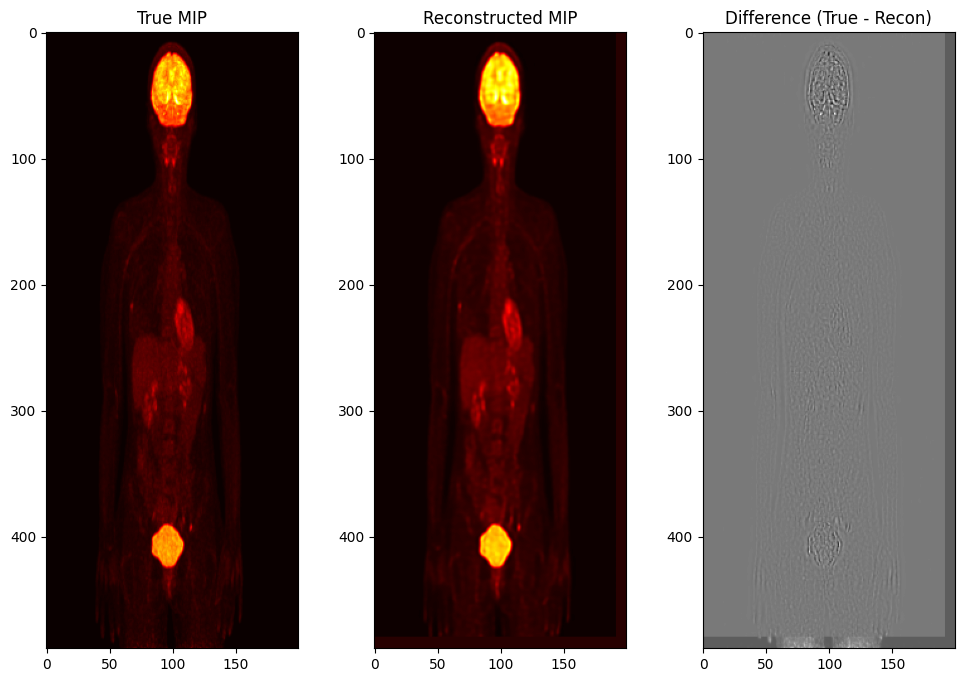

In [49]:
# display with matplotlib difference between true and reconstructed MIP at index 0

import matplotlib.pyplot as plt
idx = 2
plt.figure(figsize=(12, 8))
plt.subplot(1, 3, 1)
plt.title('True MIP')
plt.imshow(samples[idx]['true_mip'], cmap='hot')
plt.subplot(1, 3, 2)
plt.title('Reconstructed MIP')
plt.imshow(samples[idx]['recon_mip'], cmap='hot')
plt.subplot(1, 3, 3)
plt.title('Difference (True - Recon)')
plt.imshow(samples[idx]['true_mip'] - samples[idx]['recon_mip'], cmap='gray')
plt.show()

In [40]:
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure

# compute ssim and psnr between recon_mip and true_mip
# for each patient
for p in tqdm(samples, position=0, leave=True, total=samples.__len__()):
    psnr_metric = PeakSignalNoiseRatio(data_range=p['true_mip'].max() - p['true_mip'].min())
    ssim_metric = StructuralSimilarityIndexMeasure(data_range=p['true_mip'].max() - p['true_mip'].min())

    psnr = psnr_metric(
        torch.tensor(p['recon_mip']).unsqueeze(0).unsqueeze(0), 
        torch.tensor(p['true_mip']).unsqueeze(0).unsqueeze(0)
    ).item()
    ssim = ssim_metric(
        torch.tensor(p['recon_mip']).unsqueeze(0).unsqueeze(0), 
        torch.tensor(p['true_mip']).unsqueeze(0).unsqueeze(0)
    ).item()

    p['psnr'] = psnr
    p['ssim'] = ssim

100%|██████████| 76/76 [00:09<00:00,  8.26it/s]


In [42]:
print(np.mean([p['psnr'] for p in samples]), np.std([p['psnr'] for p in samples]))
print(np.mean([p['ssim'] for p in samples]), np.std([p['ssim'] for p in samples]))

43.4289093519512 5.084591836287654
0.9492137965403105 0.02594244017310826


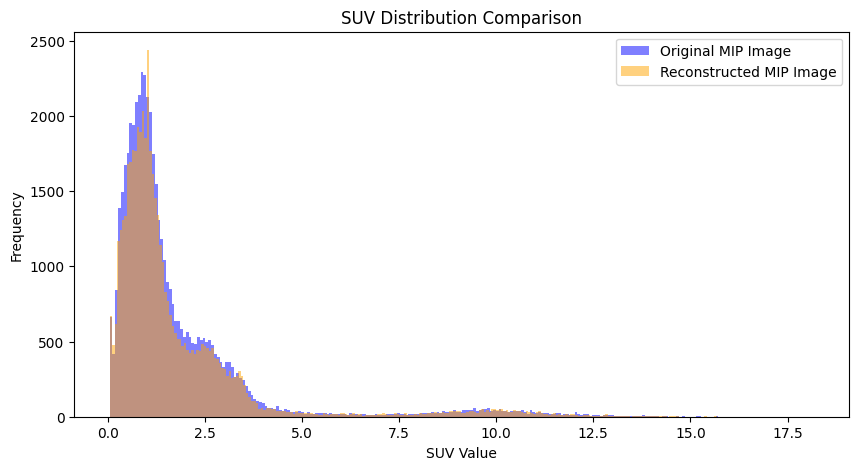

In [18]:
### Display SUV histograms per each image

# Filter values
true_filtered = true[true >= 0.05].cpu().numpy().flatten()
recon_filtered = recon[recon >= 0.05].cpu().numpy().flatten()

plt.figure(figsize=(10, 5))
plt.hist(true_filtered, bins=250, alpha=0.5, label='Original MIP Image', color='blue')
plt.hist(recon_filtered, bins=250, alpha=0.5, label='Reconstructed MIP Image', color='orange')
plt.title('SUV Distribution Comparison')
plt.xlabel('SUV Value')
plt.ylabel('Frequency')
plt.legend()

### ANO Metadata (Constructor, Versions, Protocols)

In [145]:
import os
import pandas as pd
from tqdm import tqdm

ROOT = '../datasets/EARL/Ano_metadata/'
metadata_files = os.listdir(ROOT)

tags = [
    'ProtocolName', 'BodyPartExamined', 'Manufacturer',
    'ManufacturerModelName', 'SoftwareVersions'
]

metadata_dict = {tag: [] for tag in tags}
for s_metadata in tqdm(os.listdir(ROOT), position=0, leave=True):
    path = os.path.join(ROOT, s_metadata)
    df = pd.read_csv(path)

    for tag in tags:
        if tag in df.columns:
            value = df[tag].iloc[0]
            metadata_dict[tag].append(value if not pd.isna(value) else 'N/A')

# display unique values given the different tags
for tag in tags:
    unique_values = set(metadata_dict[tag])
    print(f"{tag} unique values: {unique_values}")

100%|██████████| 946/946 [00:01<00:00, 490.73it/s]

ProtocolName unique values: {'N/A'}
BodyPartExamined unique values: {'TEP FDG', 'MN101 TEP FLUORO', 'MN121 TEP2  FDG', 'MN132 TEP4 FLUOR', 'MN108 TEP2 FLUDE'}
Manufacturer unique values: {'GE MEDICAL SYSTEMS'}
ManufacturerModelName unique values: {'Discovery 710'}
SoftwareVersions unique values: {'53.00', 'pet_mfk.56'}


### Testing spherical mask extraction

In [111]:
import SimpleITK as sitk
from scipy.ndimage import distance_transform_edt
import numpy as np

def get_largest_inscribed_sphere_mask(sitk_mask, shrinkage_mm=0.0):
    mask_arr = sitk.GetArrayFromImage(sitk_mask)
    spacing = sitk_mask.GetSpacing() # (sx, sy, sz)
    
    # On inverse le spacing pour matcher l'ordre de numpy (sz, sy, sx)
    spacing_numpy = spacing[::-1]

    if mask_arr.sum() == 0:
        return sitk_mask

    # 2. Calcul de la Transformée de Distance Euclidienne (EDT)
    # sampling permet de gérer l'anisotropie (voxels non cubiques, fréquent en PET)
    edt_map = distance_transform_edt(mask_arr, sampling=spacing_numpy)

    # 3. Trouver le point max (Centre de la sphère) et le Rayon max
    max_radius = edt_map.max()
    
    # Optionnel: Réduire légèrement le rayon pour éviter tout contact avec le bord
    final_radius = max(0, max_radius - shrinkage_mm)
    
    if final_radius == 0:
        # Si la réduction supprime la sphère, on renvoie un masque vide
        sphere_arr = np.zeros_like(mask_arr, dtype=np.uint8)
    else:
        # Récupération des coordonnées du centre (en indices matriciels)
        # argmax renvoie l'index aplati, on le convertit en (z, y, x)
        center_idx = np.unravel_index(edt_map.argmax(), edt_map.shape)
        cz, cy, cx = center_idx

        # 4. Génération du masque de la sphère
        # On crée une grille de coordonnées pour calculer la distance de chaque point au centre
        zz, yy, xx = np.ogrid[:mask_arr.shape[0], :mask_arr.shape[1], :mask_arr.shape[2]]
        
        # Calcul de la distance euclidienne au carré pondérée par le spacing
        dist2 = (
            ((zz - cz) * spacing_numpy[0])**2 + 
            ((yy - cy) * spacing_numpy[1])**2 + 
            ((xx - cx) * spacing_numpy[2])**2
        )
        
        # Création du masque binaire : 1 si distance <= rayon, 0 sinon
        sphere_arr = (dist2 <= final_radius**2).astype(np.uint8)

    # 5. Reconversion en image SimpleITK
    sphere_mask_sitk = sitk.GetImageFromArray(sphere_arr)
    sphere_mask_sitk.CopyInformation(sitk_mask) # Copie origine, spacing, direction

    return sphere_mask_sitk

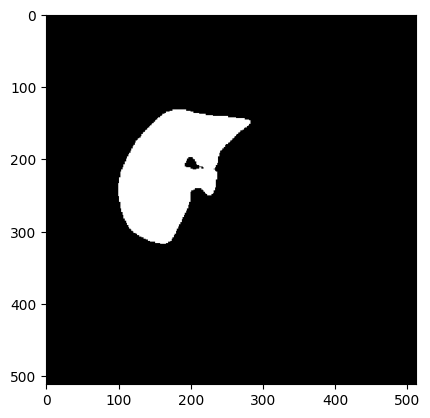

In [107]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt

suv = sitk.ReadImage('../datasets/EARL/Ano_Nifti/9401152847m/PT_TEPTAPAC_Ano.nii.gz')
mask = sitk.ReadImage('../datasets/EARL/Ano_Nifti/9401152847m/liver.nii.gz')

mask_arr = sitk.GetArrayFromImage(mask)

plt.imshow(mask_arr[150, :, :], cmap='gray')

In [ ]:
mask_arr = sitk.GetArrayFromImage(mask)
spacing = mask.GetSpacing() # (sx, sy, sz)
spacing_numpy = spacing[::-1]

edt_map = distance_transform_edt(mask_arr, sampling=spacing_numpy)

In [135]:
max_radius = edt_map.max()
final_radius = max(0, max_radius - 1.0)

In [136]:
cz, cy, cx = np.unravel_index(edt_map.argmax(), edt_map.shape)
zz, yy, xx = np.ogrid[:mask_arr.shape[0], :mask_arr.shape[1], :mask_arr.shape[2]]

dist2 = (
    ((zz - cz) * spacing_numpy[0])**2 + 
    ((yy - cy) * spacing_numpy[1])**2 + 
    ((xx - cx) * spacing_numpy[2])**2
)
        
# Création du masque binaire : 1 si distance <= rayon, 0 sinon
sphere_arr = (dist2 <= final_radius ** 2).astype(np.uint8)

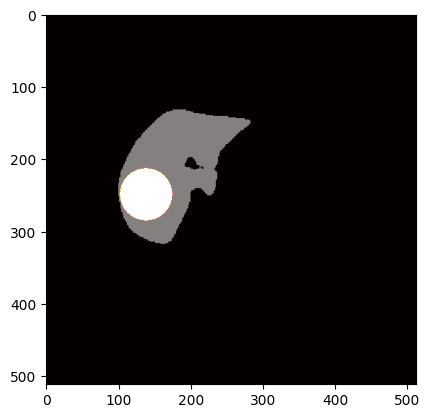

In [139]:
plt.imshow(mask_arr[150, :, :], cmap='gray')
plt.imshow(sphere_arr[150, :, :], cmap='hot', alpha=0.5)

In [140]:
sphere_mask_sitk = sitk.GetImageFromArray(sphere_arr)
sphere_mask_sitk.CopyInformation(mask) # Copie origine, spacing, direction

In [143]:
import SimpleITK as sitk
import os
from tqdm import tqdm

root = '../datasets/EARL/Ano_Nifti/'

pet_spacing, earl_spacing = set(), set()
for s in tqdm(os.listdir(root), position=0, leave=True, total=os.listdir(root).__len__()):
    subject_path = os.path.join(root, s)
    pet_img = sitk.ReadImage(os.path.join(subject_path, 'PT_TEPTAPAC_Ano.nii.gz'))
    earl_img = sitk.ReadImage(os.path.join(subject_path, 'PT_TEPTAPRECONEARL_Ano.nii.gz'))

    pet_spacing.add(pet_img.GetSpacing())
    earl_spacing.add(earl_img.GetSpacing())



100%|██████████| 943/943 [11:55<00:00,  1.32it/s]


### DataModule: test du datamodule de MONAI pour chargement des PETs à la volée

In [ ]:
from modules.data import PETTranslationDataModule

datamodule = PETTranslationDataModule(
    root_dir = '../datasets/EARL/Ano_Nifti',
    train_ratio = 1.0,
    batch_size = 4,
    patch_size = (64, 64, 64),
    spacing = (2.0, 2.0, 2.0),
    cache_rate = 0.0,
    num_workers = 4
)

datamodule.prepare_data()
datamodule.setup()

for batch in datamodule.train_dataloader():
    print(batch['source'].shape, batch['target'].shape)